In [1]:
# Imports
import importlib
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sys.path.append('/Users/work/Desktop/Research/Experimental Data/Fall-2024-Cl2/_shared_packages')
import process_cl2_logfile as process_cl2#This underline us unavoidable
importlib.reload(process_cl2)

# Load the file...
info = (('data/log_9-16_humidity_sweep.csv','09-16-24 Humidity Sweep (10-60%)'),
        ('data/log_9-17_fixed_ch4_vary_cl2_high.csv','09-17-24 Vary Cl2 (30-90 ppm) at Fixed CH4'),
        ('data/log_9-17_fixed_cl2_vary_ch4_high.csv','09-17-24 Vary CH4 (10-180 ppm) at Fixed Cl2'),
        ('data/log_9-19_high_1-to-1_sweep.csv','09-19-24 Sweep 1-to-1 Cl2 and CH4 (30-90 ppm)'),
        ('data/log_9-19_med_1-to-1_sweep.csv','09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4'),
        ('data/log_9-19_med_1-to-1_sweep.csv','09-19-24 Sweep 1-to-1 Cl2 and CH4 (10-20 ppm)')
        )
hush=True
raw_data = process_cl2.extract_data(info,hush)
ftir_fields_to_rebind = (('CH4 (PF) 191c average','FTIR: CH4 (ppm)'),('CO2 ppm 191c average','FTIR: CO2 (ppm)'),
                         ('CO ppm 191C (1of2) average','FTIR: CO (ppm)'),('Formaldehyde 191c average','FTIR: CH2O (ppm)'),)
process_cl2.rebind_ftir_prn(raw_data['09-16-24 Humidity Sweep (10-60%)'],'data/ftir_9-16_v2.prn',ftir_fields_to_rebind,hush)
process_cl2.rebind_ftir_prn(raw_data['09-17-24 Vary Cl2 (30-90 ppm) at Fixed CH4'],'data/ftir_9-17_v2.prn',ftir_fields_to_rebind,hush)
process_cl2.rebind_ftir_prn(raw_data['09-17-24 Vary CH4 (10-180 ppm) at Fixed Cl2'],'data/ftir_9-17_v2.prn',ftir_fields_to_rebind,hush)
process_cl2.rebind_ftir_prn(raw_data['09-19-24 Sweep 1-to-1 Cl2 and CH4 (30-90 ppm)'],'data/ftir_9-19_v1.prn',ftir_fields_to_rebind,hush)
process_cl2.rebind_ftir_prn(raw_data['09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4'],'data/ftir_9-19_v1.prn',ftir_fields_to_rebind,hush)
process_cl2.rebind_ftir_prn(raw_data['09-19-24 Sweep 1-to-1 Cl2 and CH4 (10-20 ppm)'],'data/ftir_9-19_v1.prn',ftir_fields_to_rebind,hush)
for df in raw_data.values():
    df['FTIR: CH2O (ppm)']+=0.5 #One can see on inspection that the 'baseline' CH2O value is -0.5, not 0, for some reason. We correct that.

# Suppress a printout
pass

<h1> Loading, trimming, and re-binding log files </h1>

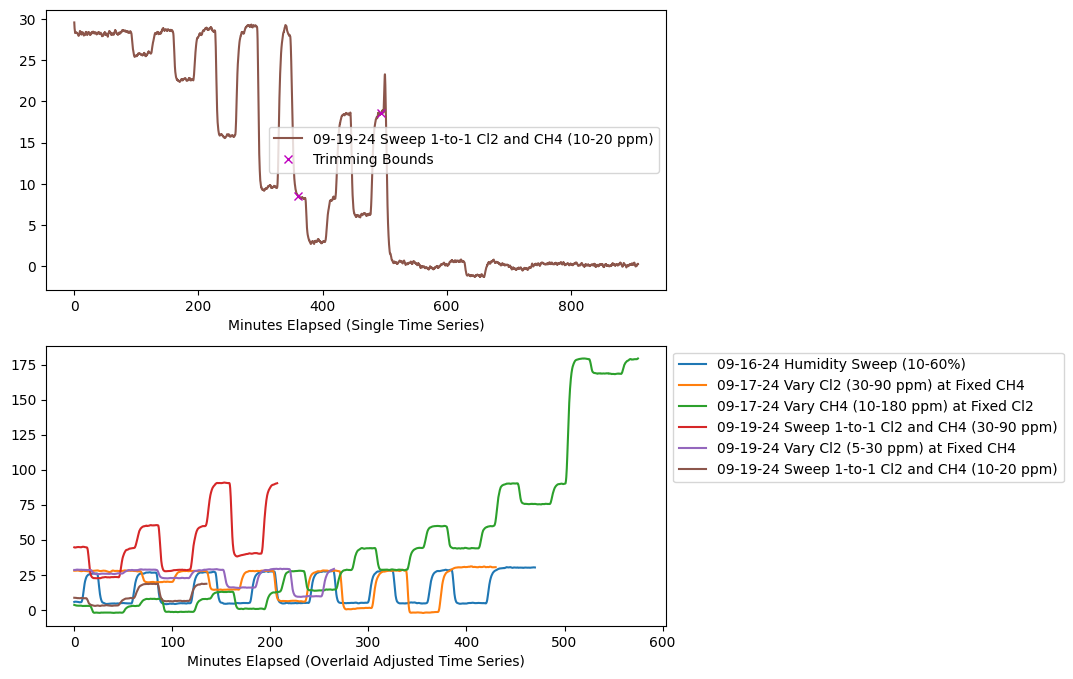

In [2]:
@np.vectorize
def calibrate_cl2(mv):
    return (mv-43)*30/(80.5-43)

importlib.reload(process_cl2)
trim_params=((350,820),
             (0,430),
             (20,595),
             (16,223),
             (75,340),
             (360,495),
             )
(data,ax1,ax2) = process_cl2.trim_dataframes(raw_data,trim_params,
                                   plot=True,which_field='FTIR: CH4 (ppm)',which_df=5)
rf = process_cl2.RemovalFinder(data,"09-24_cl2_sweeps_no_cofeed")

<h1> Humidity Sweep 9-16 </h1>

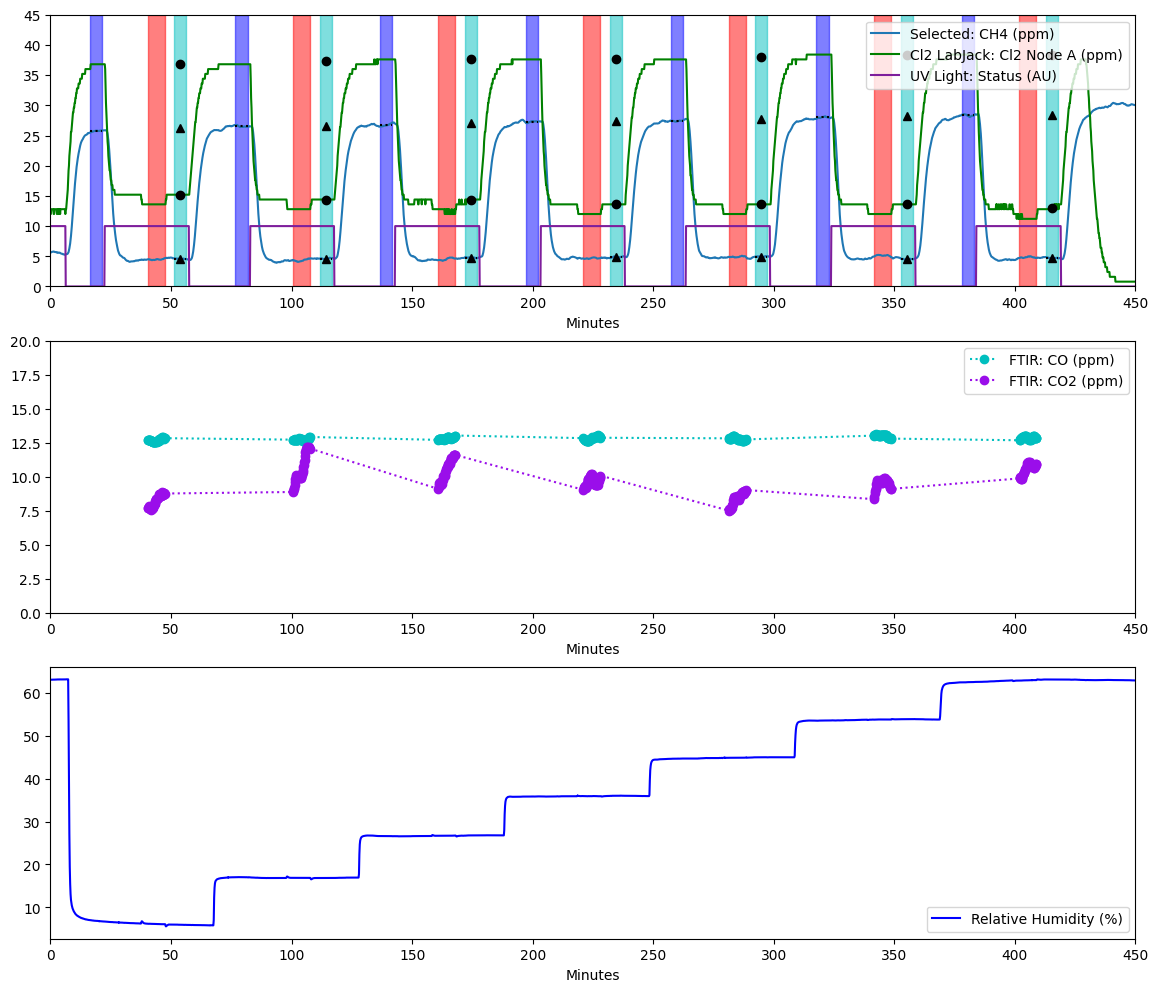

In [3]:
importlib.reload(process_cl2)

current_experiment = '09-16-24 Humidity Sweep (10-60%)'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 Node A (ppm)'] = calibrate_cl2(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']
# Prep the plot region
(fig, axs) = plt.subplots(nrows=3,figsize=(14,12),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=True)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 Node A (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=True)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 Node A (ppm)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],10*data[current_experiment]['UV Light: Actual Status'],color='xkcd:purple',label='UV Light: Status (AU)')
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
axs[0].set_xlim(0,500)
axs[0].set_ylim(0,45)

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,20)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")

# Throw in a plot of the RH
axs[2].plot(data[current_experiment]['Minutes'],data[current_experiment]['Humidity Probe: Rel. Humidity (%)']*(1.0/(1-6.0/200.0)),
        label='Relative Humidity (%)',color='b')
axs[2].set_xlim(0,450)
axs[2].set_xlabel("Minutes")
axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].legend()

pass

<h1> Sweep Cl2 at Fixed CH4 9-17 </h2>

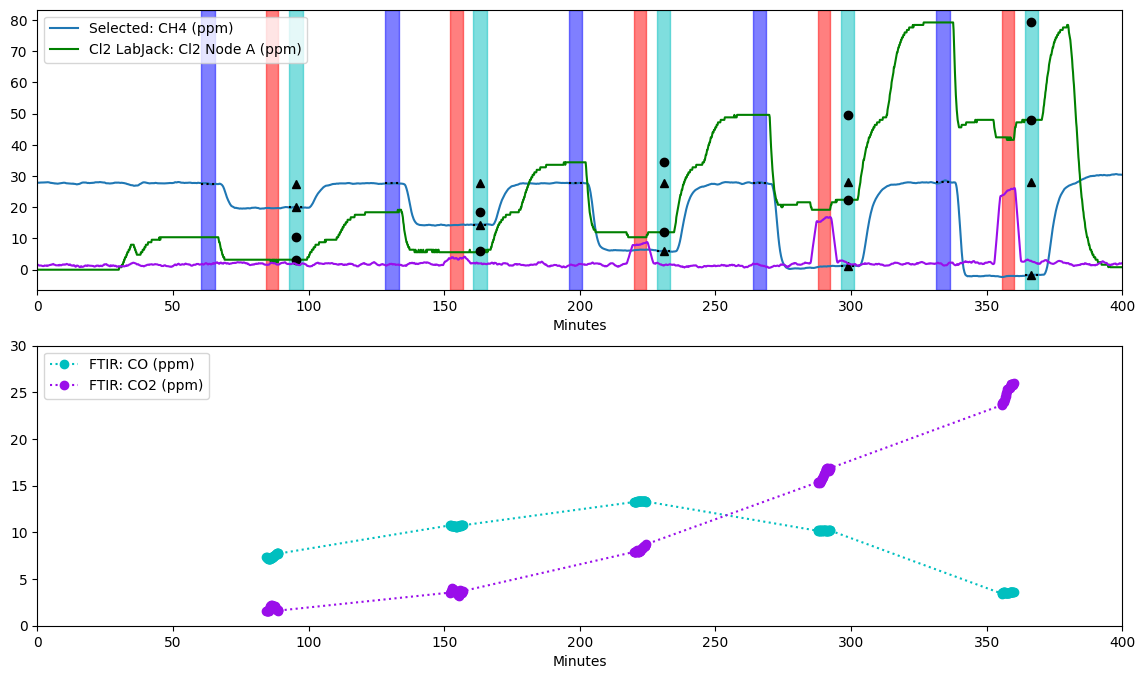

In [4]:
importlib.reload(process_cl2)
current_experiment = '09-17-24 Vary Cl2 (30-90 ppm) at Fixed CH4'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 Node A (ppm)'] = calibrate_cl2(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=2,figsize=(14,8),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=True)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 Node A (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 Node A (ppm)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'],color='xkcd:violet')

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
axs[0].set_xlim(0,400)

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,30)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")

pass


<h1>Sweep CH4 at fixed Cl2</h1>

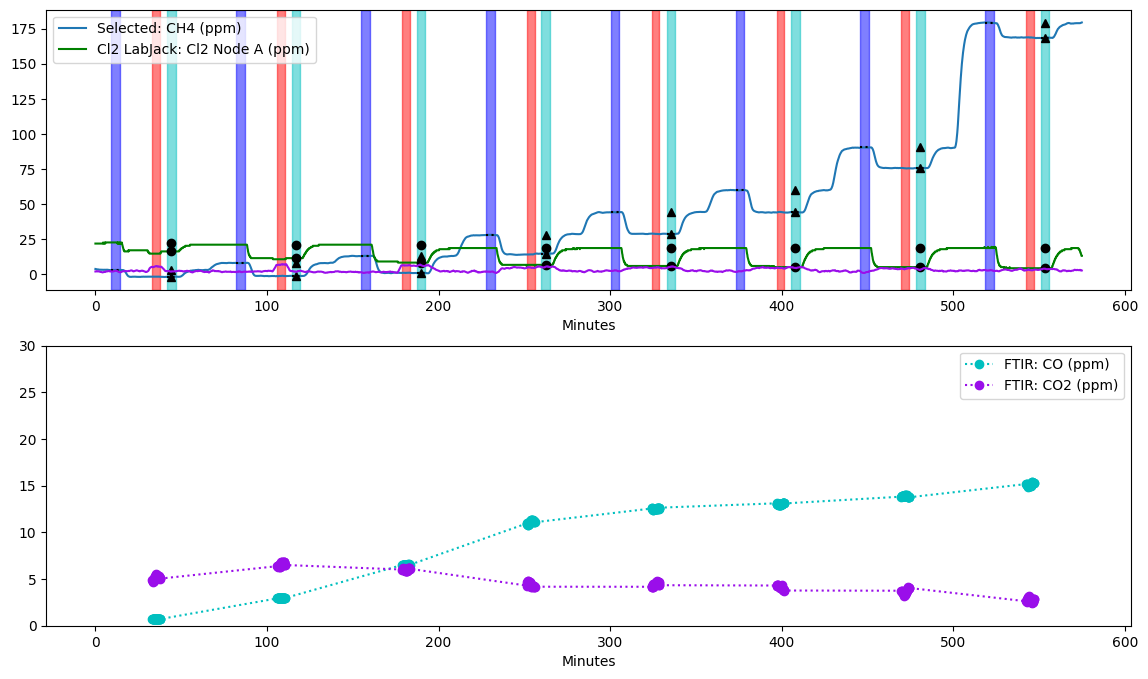

In [5]:
importlib.reload(process_cl2)
current_experiment = '09-17-24 Vary CH4 (10-180 ppm) at Fixed Cl2'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 Node A (ppm)'] =  calibrate_cl2(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=2,figsize=(14,8),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=570,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 Node A (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=570,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 Node A (ppm)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'],color='xkcd:violet')

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,30)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")

pass

<h1>Vary CH4 and Cl2 together, keeping 1:1 ratio, 30-90 ppm</h1>

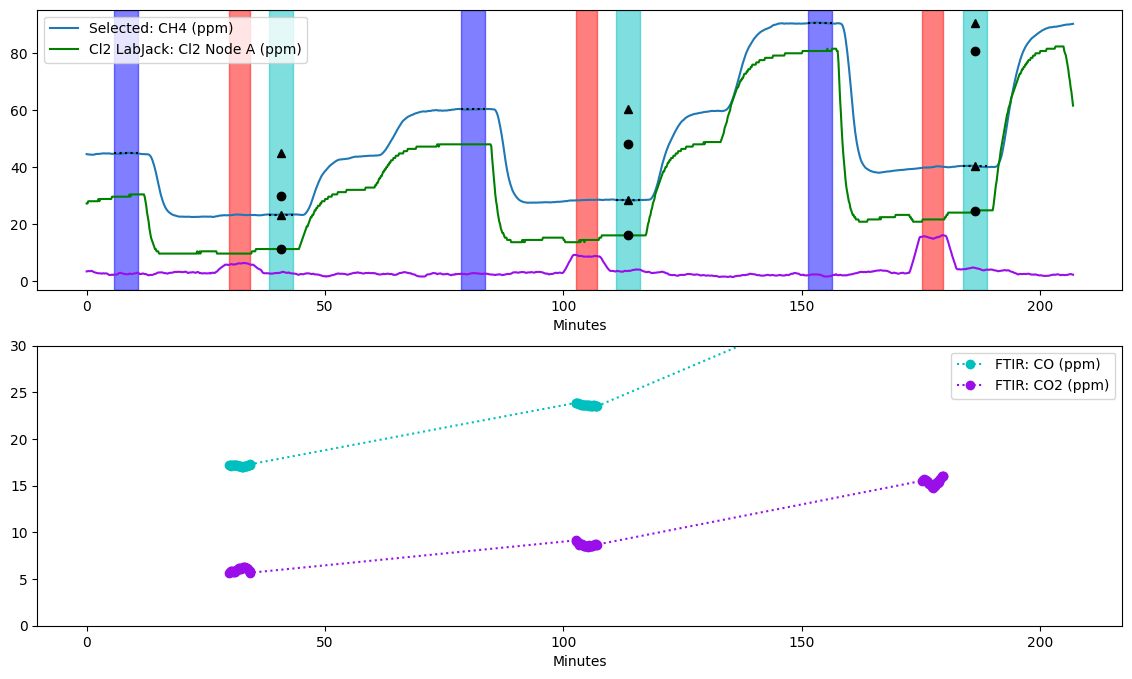

In [6]:
importlib.reload(process_cl2)
current_experiment = '09-19-24 Sweep 1-to-1 Cl2 and CH4 (30-90 ppm)'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 Node A (ppm)'] =  calibrate_cl2(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=2,figsize=(14,8),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=570,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 Node A (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=570,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 Node A (ppm)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'],color='xkcd:violet')

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,30)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")

pass

<h1>Vary Cl2 for Fixed CH4, 5-30 ppm</h1>

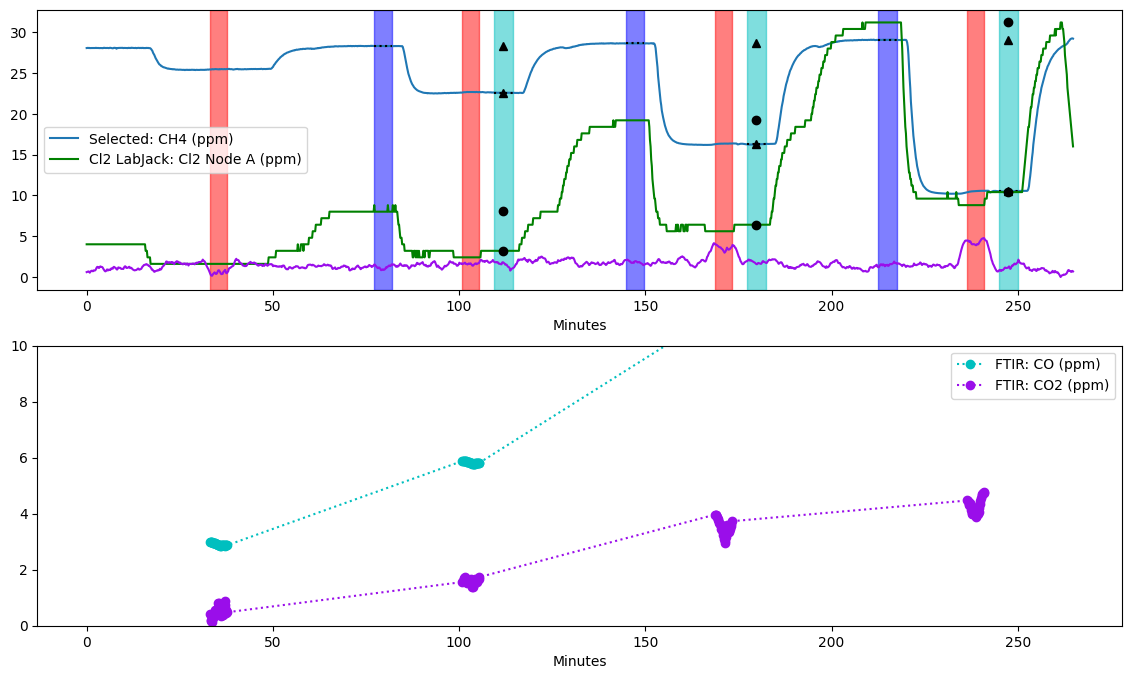

In [7]:
importlib.reload(process_cl2)
current_experiment = '09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 Node A (ppm)'] =  calibrate_cl2(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])

data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['Picarro: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=2,figsize=(14,8),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=50,end_time=570,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 Node A (ppm)')
rf.autofind_removal(current_experiment,start_time=50,end_time=570,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 Node A (ppm)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'],color='xkcd:violet')

# First sample has a kind of messed up Cl2 value (hadn't quite stabilized and is still drifting down), so I excluded it.

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,10)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")

pass

<h1>Vary CH4 and Cl2 in 1:1 ratio, 10 and 20 ppm</h1>

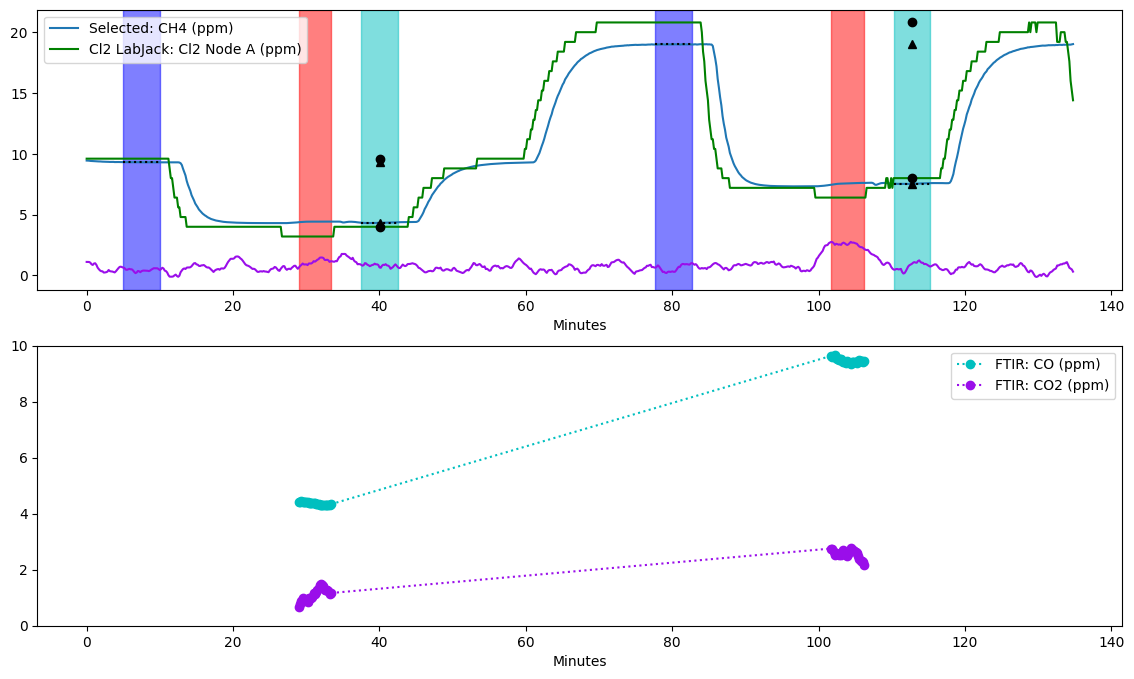

In [8]:
importlib.reload(process_cl2)
current_experiment = '09-19-24 Sweep 1-to-1 Cl2 and CH4 (10-20 ppm)'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 Node A (ppm)'] =  calibrate_cl2(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['Picarro: CH4 (ppm)']


# Prep the plot region
(fig, axs) = plt.subplots(nrows=2,figsize=(14,8),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=570,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 Node A (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=570,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 Node A (ppm)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'],color='xkcd:violet')

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,10)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")

pass

In [9]:
rf.export_conversion_results_to_csv('/Users/work/Desktop/Research/Experimental Data/Fall-2024-Cl2/_exported_data/')
rf.export_bypass_periods('/Users/work/Desktop/Research/Experimental Data/Fall-2024-Cl2/_exported_data/')